In [62]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import QuantileTransformer
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error,r2_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PowerTransformer
import statsmodels.api as sm
from sklearn.metrics import mean_squared_error as mse
from sklearn.metrics import mean_absolute_error as mae
from scipy.stats import boxcox
pd.options.display.max_rows = 50
pd.options.display.max_columns = 999
import warnings
warnings.filterwarnings('ignore')

In [63]:
def load_original_data():
    return pd.read_excel("Data/Data_MidTerm_Project_Real_State_Regression.xls" )

In [64]:
def clean_data(df):
    df=df.dropna()
    ## droping columns
    df=df.drop(columns=['id','view','lat','long','sqft_above', 'sqft_basement', 'sqft_lot15','sqft_lot'])
    ## removing duplicates
    df=df.drop_duplicates()
    #date changed to dd/mm/year format
    df['date'] = df['date'].dt.strftime('%Y')
    #changing price values to currency format
    df['price'] = df['price'].apply(lambda x: "{:.2f}".format((x/1000)))
    df['price'] = df['price'].astype(float)
    return df

In [65]:
re_df=load_original_data()
re_df=clean_data(re_df)

In [66]:
re_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 21596 entries, 0 to 21596
Data columns (total 13 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   date           21596 non-null  object 
 1   bedrooms       21596 non-null  int64  
 2   bathrooms      21596 non-null  float64
 3   sqft_living    21596 non-null  int64  
 4   floors         21596 non-null  float64
 5   waterfront     21596 non-null  int64  
 6   condition      21596 non-null  int64  
 7   grade          21596 non-null  int64  
 8   yr_built       21596 non-null  int64  
 9   yr_renovated   21596 non-null  int64  
 10  zipcode        21596 non-null  int64  
 11  sqft_living15  21596 non-null  int64  
 12  price          21596 non-null  float64
dtypes: float64(3), int64(9), object(1)
memory usage: 2.3+ MB


In [67]:
re_df.shape

(21596, 13)

In [68]:
Q1 = re_df['bathrooms'].quantile(0.25)
Q3 = re_df['bathrooms'].quantile(0.75)

IQR = Q3-Q1

lower_limit = Q1 - 1.5*IQR
upper_limit = Q3 + 1.5*IQR

re_df['bathrooms'] = np.where(re_df['bathrooms']>upper_limit,upper_limit,re_df['bathrooms'])
re_df['bathrooms'] = np.where(re_df['bathrooms']<lower_limit,lower_limit,re_df['bathrooms'])

### Plotting

Plot the distribution of price vs. number of bedrooms, price vs. number of bathrooms, price vs. condition, price vs. floors, price vs. grade, price vs. view, and price vs. waterfront.

State your observation for each one of those graphs. 
Do you see any trends in prices vs the rest of those variables individually? This can also be used for EDA to identify some data cleaning operations that you might need to perform further.

In [69]:
re_df[['bedrooms','bathrooms', 'floors','waterfront','condition','grade','yr_built','yr_renovated','zipcode']] = re_df[['bedrooms','bathrooms', 'floors','waterfront','condition','grade','yr_built','yr_renovated','zipcode']].astype(str)
# converting categorical columns

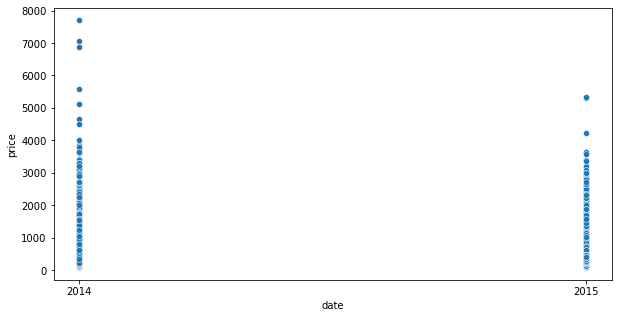

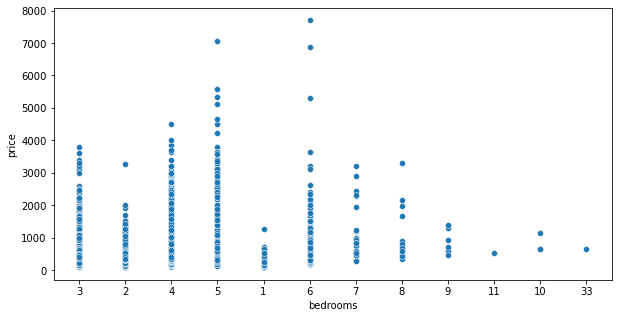

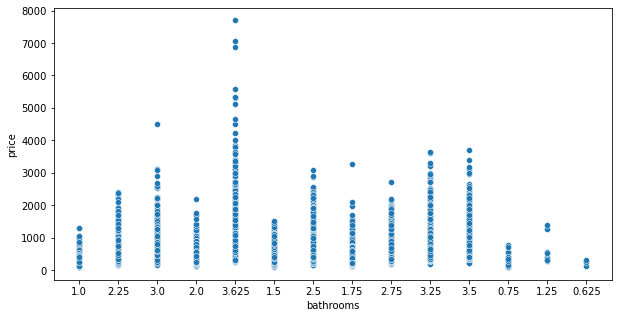

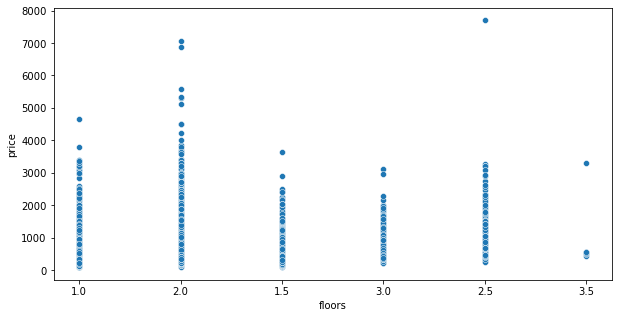

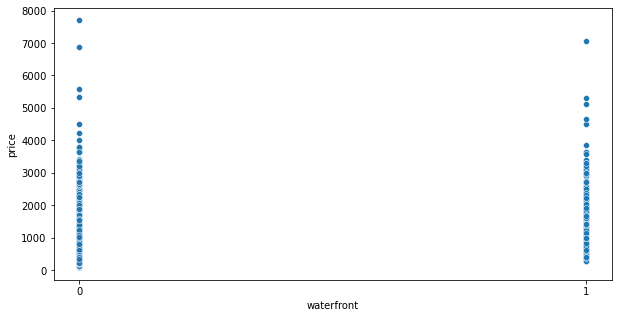

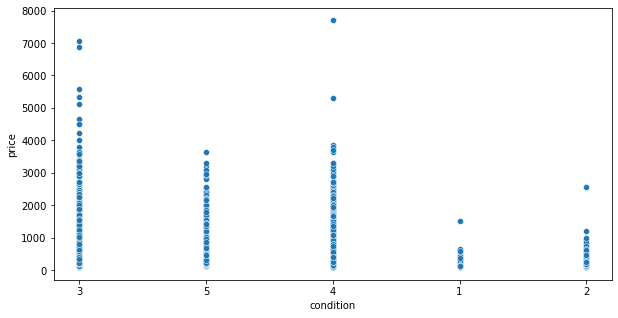

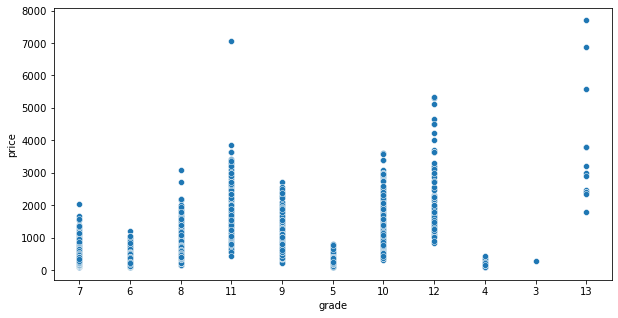

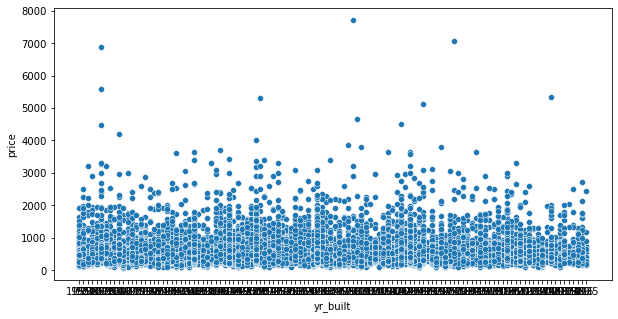

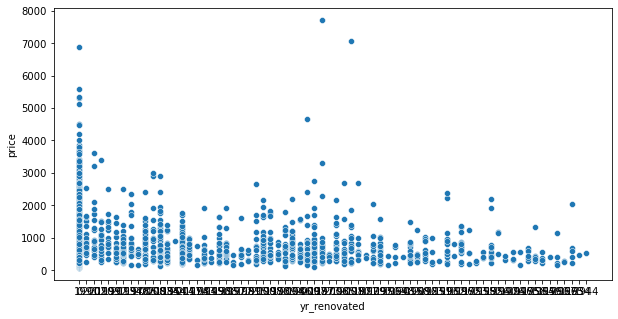

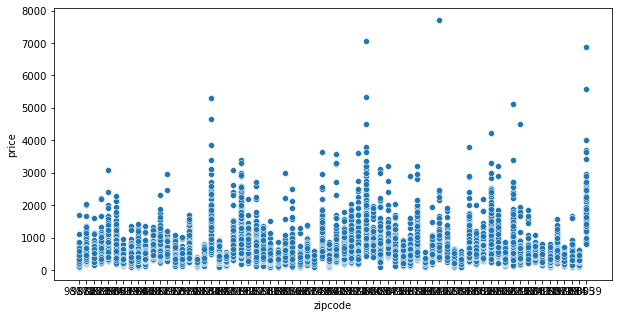

In [70]:
for c in re_df.select_dtypes(object):
    plt.figure(figsize=(10,5))
    sns.scatterplot(y='price',x=re_df[c],data=re_df)
    plt.show()

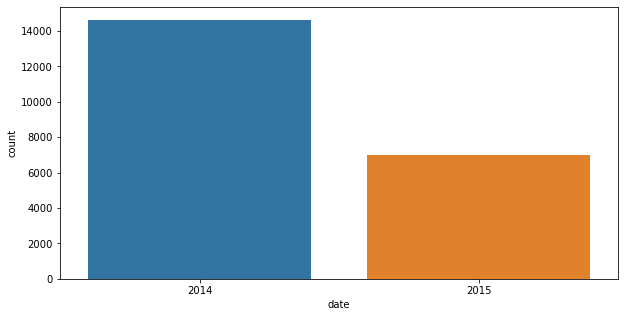

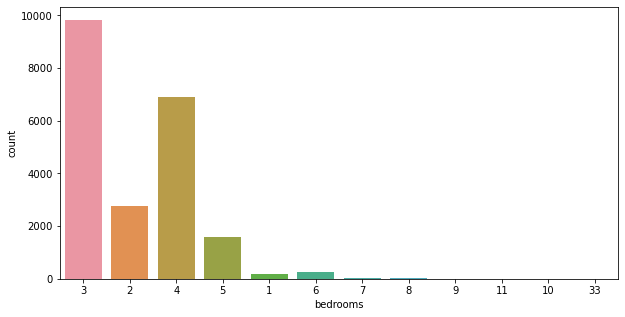

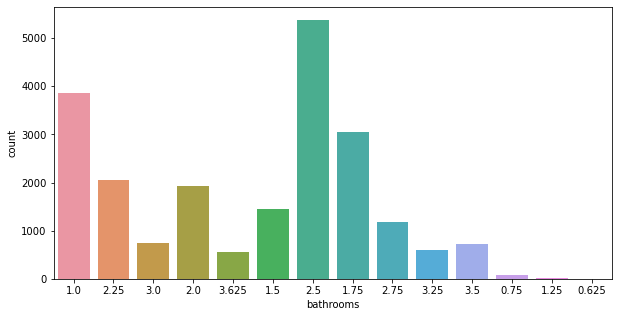

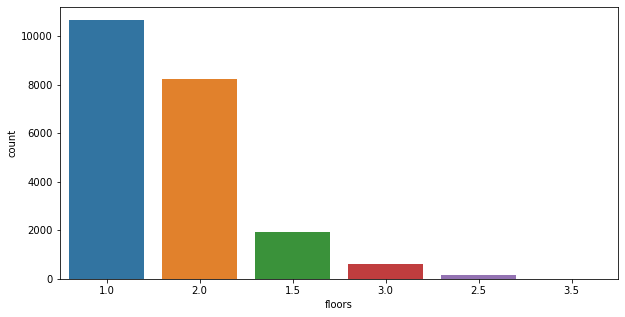

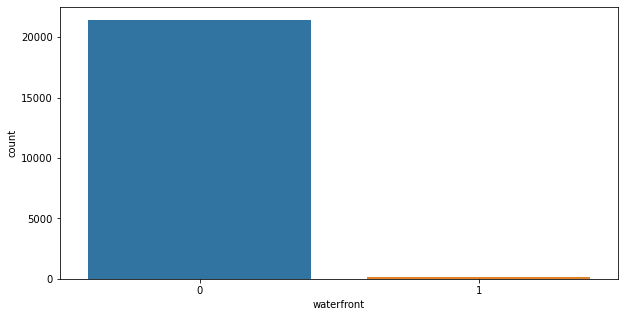

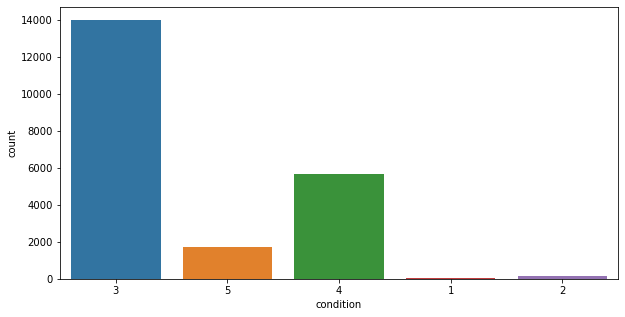

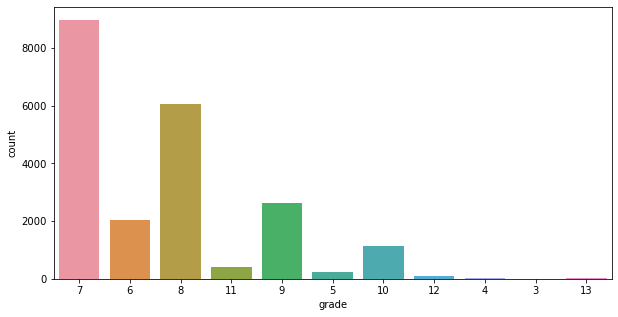

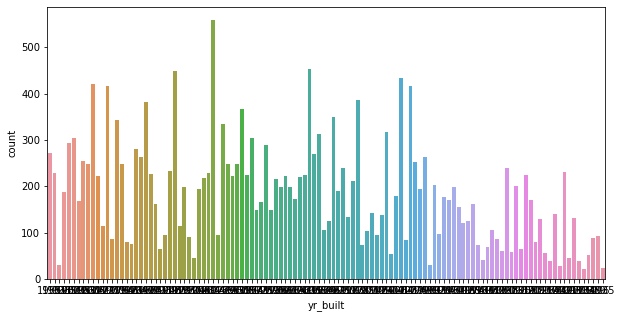

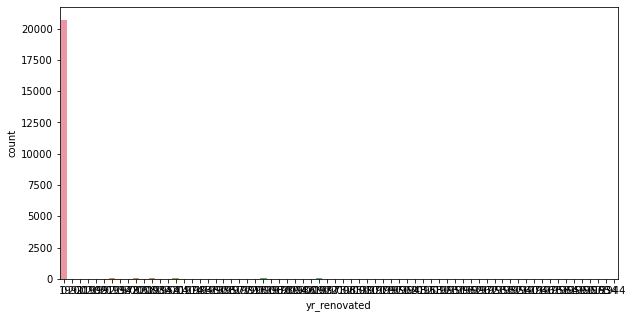

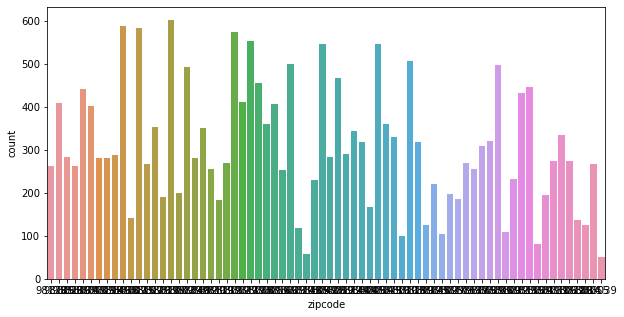

In [71]:
for c in re_df.select_dtypes(object):
    plt.figure(figsize=(10,5))
    sns.countplot(x=re_df[c],data=re_df)
    plt.show()

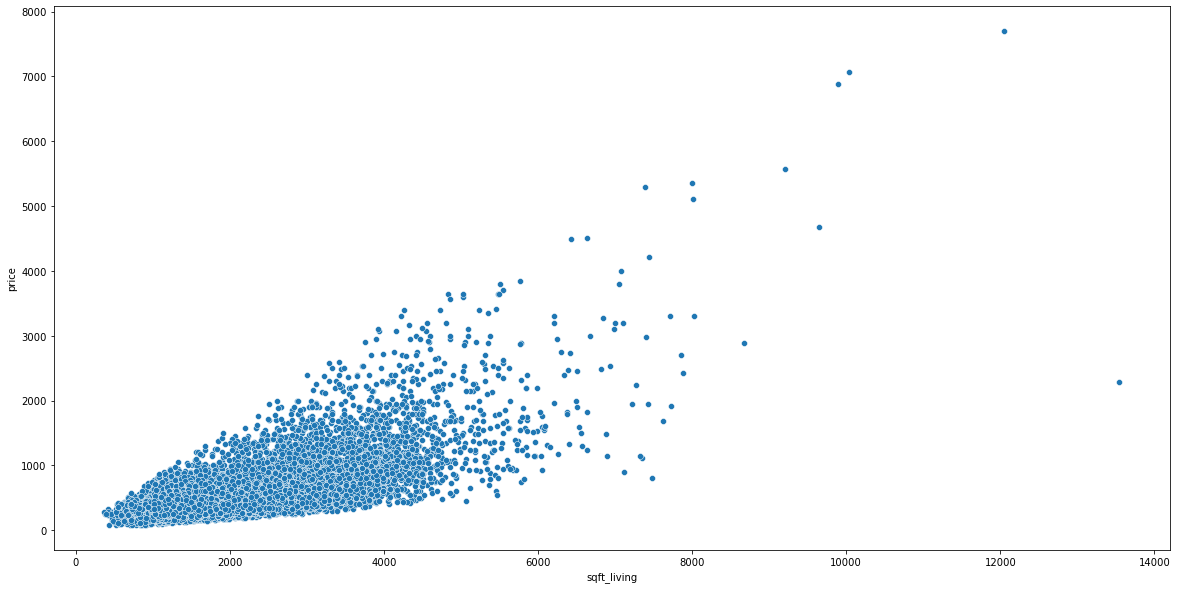

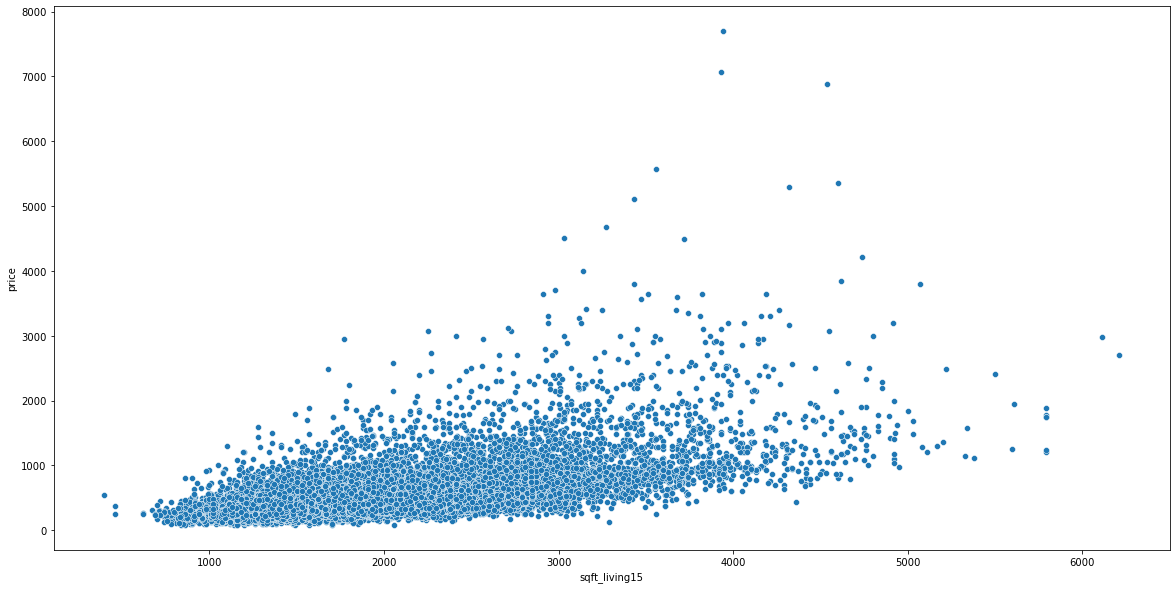

In [72]:
for c in re_df.select_dtypes(int):
    plt.figure(figsize=(20,10))
    sns.scatterplot(y='price',x=re_df[c],data=re_df)
    plt.show()

## removing outliers

sns.boxplot(re_df.sqft_living)

Q1 = re_df.sqft_living.quantile(0.25)
Q3 = re_df.sqft_living.quantile(0.75) 
IQR = Q3 - Q1

filter = (re_df['sqft_living'] >= Q1 - 1.5 * IQR) & (re_df['sqft_living'] <= Q3 + 1.5 *IQR)
re_df=re_df.loc[filter]

re_df.sqft_living.hist()

sns.boxplot(re_df.sqft_lot)

Q1 = re_df.sqft_lot.quantile(0.25)
Q3 = re_df.sqft_lot.quantile(0.75)
IQR = Q3 - Q1
filter = (re_df['sqft_lot'] >= Q1 - 1.5 * IQR) & (re_df['sqft_lot'] <= Q3 + 1.5 *IQR)
re_df=re_df.loc[filter]

re_df.sqft_lot.hist()

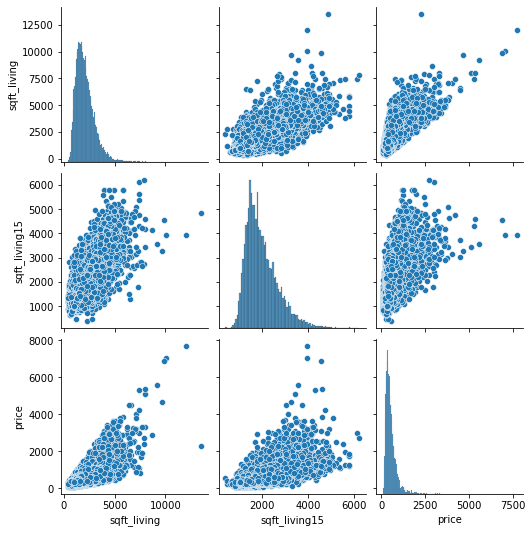

In [73]:
sns.pairplot(re_df)
plt.show()

## Data transformation

In [74]:
sqft_living_transformed,lam=boxcox(re_df['sqft_living'])

<AxesSubplot:ylabel='Count'>

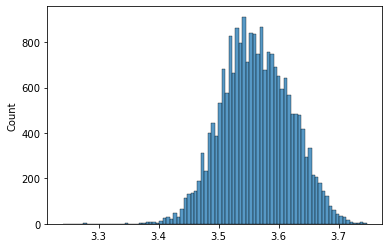

In [75]:
sqft_living15_transformed,lam=boxcox(re_df['sqft_living15'])
sns.histplot(sqft_living15_transformed)

<AxesSubplot:xlabel='sqft_living', ylabel='Density'>

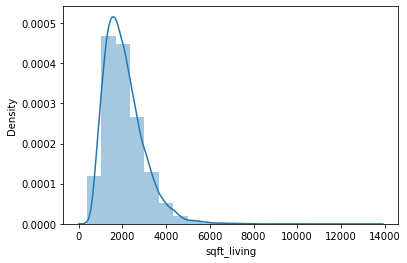

In [76]:
sns.distplot((re_df['sqft_living']), bins=20)

<AxesSubplot:xlabel='sqft_living15', ylabel='Density'>

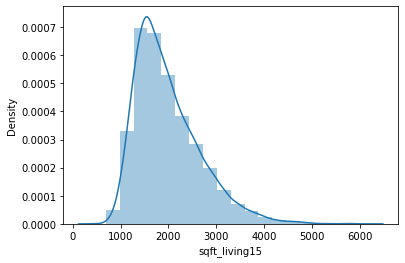

In [77]:
sns.distplot((re_df['sqft_living15']), bins=20)

In [78]:
#checking correlation
numericals_features=re_df._get_numeric_data()
correlations = numericals_features.corr()
correlations

,sqft_living,sqft_living15,price
sqft_living,1.000000,0.756398,0.701951
sqft_living15,0.756398,1.000000,0.585251
price,0.701951,0.585251,1.000000


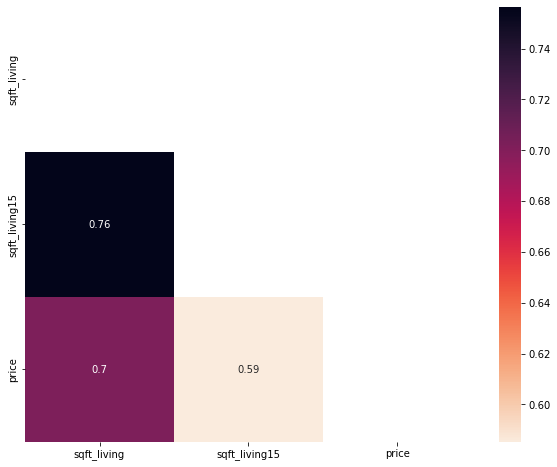

In [79]:
cmap = sns.cm.rocket_r  ## for reversing the colors
mask=np.zeros_like(numericals_features.corr())
mask[np.triu_indices_from(mask)]=True
fig, ax=plt.subplots(figsize=(10, 8))
ax=sns.heatmap(numericals_features.corr(), mask=mask, annot=True,cmap=cmap)
plt.show()

In [80]:
#XY Split
x=re_df.drop('price', axis=1)
y=re_df.price

In [81]:
x

,date,bedrooms,bathrooms,sqft_living,floors,waterfront,condition,grade,yr_built,yr_renovated,zipcode,sqft_living15
0,2014,3,1.0,1180,1.0,0,3,7,1955,0,98178,1340
1,2014,3,2.25,2570,2.0,0,3,7,1951,1991,98125,1690
2,2015,2,1.0,770,1.0,0,3,6,1933,0,98028,2720
3,2014,4,3.0,1960,1.0,0,5,7,1965,0,98136,1360
4,2015,3,2.0,1680,1.0,0,3,8,1987,0,98074,1800
...,...,...,...,...,...,...,...,...,...,...,...,...
21592,2014,3,2.5,1530,3.0,0,3,8,2009,0,98103,1530
21593,2015,4,2.5,2310,2.0,0,3,8,2014,0,98146,1830
21594,2014,2,0.75,1020,2.0,0,3,7,2009,0,98144,1020
21595,2015,3,2.5,1600,2.0,0,3,8,2004,0,98027,1410


In [82]:
numericals_features =x._get_numeric_data()
# numericals =data.select_dtypes(np.number)
numericals_features

,sqft_living,sqft_living15
0,1180,1340
1,2570,1690
2,770,2720
3,1960,1360
4,1680,1800
...,...,...
21592,1530,1530
21593,2310,1830
21594,1020,1020
21595,1600,1410


In [83]:
numericals_features.describe()

,sqft_living,sqft_living15
count,21596.000000,21596.000000
mean,2080.265373,1986.597935
std,918.089865,685.238442
min,370.000000,399.000000
25%,1430.000000,1490.000000
50%,1910.000000,1840.000000
75%,2550.000000,2360.000000
max,13540.000000,6210.000000


In [84]:
#Get Categorical data

categoricals_features = x.select_dtypes(object)
categoricals_features

,date,bedrooms,bathrooms,floors,waterfront,condition,grade,yr_built,yr_renovated,zipcode
0,2014,3,1.0,1.0,0,3,7,1955,0,98178
1,2014,3,2.25,2.0,0,3,7,1951,1991,98125
2,2015,2,1.0,1.0,0,3,6,1933,0,98028
3,2014,4,3.0,1.0,0,5,7,1965,0,98136
4,2015,3,2.0,1.0,0,3,8,1987,0,98074
...,...,...,...,...,...,...,...,...,...,...
21592,2014,3,2.5,3.0,0,3,8,2009,0,98103
21593,2015,4,2.5,2.0,0,3,8,2014,0,98146
21594,2014,2,0.75,2.0,0,3,7,2009,0,98144
21595,2015,3,2.5,2.0,0,3,8,2004,0,98027


In [85]:
# get dummies pandas
categoricals_features=pd.get_dummies(categoricals_features, drop_first=True)
categoricals_features

,date_2015,bedrooms_10,bedrooms_11,bedrooms_2,bedrooms_3,bedrooms_33,bedrooms_4,bedrooms_5,bedrooms_6,bedrooms_7,bedrooms_8,bedrooms_9,bathrooms_0.75,bathrooms_1.0,bathrooms_1.25,bathrooms_1.5,bathrooms_1.75,bathrooms_2.0,bathrooms_2.25,bathrooms_2.5,bathrooms_2.75,bathrooms_3.0,bathrooms_3.25,bathrooms_3.5,bathrooms_3.625,floors_1.5,floors_2.0,floors_2.5,floors_3.0,floors_3.5,waterfront_1,condition_2,condition_3,condition_4,condition_5,grade_11,grade_12,grade_13,grade_3,grade_4,grade_5,grade_6,grade_7,grade_8,grade_9,yr_built_1901,yr_built_1902,yr_built_1903,yr_built_1904,yr_built_1905,yr_built_1906,yr_built_1907,yr_built_1908,yr_built_1909,yr_built_1910,yr_built_1911,yr_built_1912,yr_built_1913,yr_built_1914,yr_built_1915,yr_built_1916,yr_built_1917,yr_built_1918,yr_built_1919,yr_built_1920,yr_built_1921,yr_built_1922,yr_built_1923,yr_built_1924,yr_built_1925,yr_built_1926,yr_built_1927,yr_built_1928,yr_built_1929,yr_built_1930,yr_built_1931,yr_built_1932,yr_built_1933,yr_built_1934,yr_built_1935,yr_built_1936,yr_built_1937,yr_built_1938,yr_built_1939,yr_built_1940,yr_built_1941,yr_built_1942,yr_built_1943,yr_built_1944,yr_built_1945,yr_built_1946,yr_built_1947,yr_built_1948,yr_built_1949,yr_built_1950,yr_built_1951,yr_built_1952,yr_built_1953,yr_built_1954,yr_built_1955,yr_built_1956,yr_built_1957,yr_built_1958,yr_built_1959,yr_built_1960,yr_built_1961,yr_built_1962,yr_built_1963,yr_built_1964,yr_built_1965,yr_built_1966,yr_built_1967,yr_built_1968,yr_built_1969,yr_built_1970,yr_built_1971,yr_built_1972,yr_built_1973,yr_built_1974,yr_built_1975,yr_built_1976,yr_built_1977,yr_built_1978,yr_built_1979,yr_built_1980,yr_built_1981,yr_built_1982,yr_built_1983,yr_built_1984,yr_built_1985,yr_built_1986,yr_built_1987,yr_built_1988,yr_built_1989,yr_built_1990,yr_built_1991,yr_built_1992,yr_built_1993,yr_built_1994,yr_built_1995,yr_built_1996,yr_built_1997,yr_built_1998,yr_built_1999,yr_built_2000,yr_built_2001,yr_built_2002,yr_built_2003,yr_built_2004,yr_built_2005,yr_built_2006,yr_built_2007,yr_built_2008,yr_built_2009,yr_built_2010,yr_built_2011,yr_built_2012,yr_built_2013,yr_built_2014,yr_built_2015,yr_renovated_1934,yr_renovated_1940,yr_renovated_1944,yr_renovated_1945,yr_renovated_1946,yr_renovated_1948,yr_renovated_1950,yr_renovated_1951,yr_renovated_1953,yr_renovated_1954,yr_renovated_1955,yr_renovated_1956,yr_renovated_1957,yr_renovated_1958,yr_renovated_1959,yr_renovated_1960,yr_renovated_1962,yr_renovated_1963,yr_renovated_1964,yr_renovated_1965,yr_renovated_1967,yr_renovated_1968,yr_renovated_1969,yr_renovated_1970,yr_renovated_1971,yr_renovated_1972,yr_renovated_1973,yr_renovated_1974,yr_renovated_1975,yr_renovated_1976,yr_renovated_1977,yr_renovated_1978,yr_renovated_1979,yr_renovated_1980,yr_renovated_1981,yr_renovated_1982,yr_renovated_1983,yr_renovated_1984,yr_renovated_1985,yr_renovated_1986,yr_renovated_1987,yr_renovated_1988,yr_renovated_1989,yr_renovated_1990,yr_renovated_1991,yr_renovated_1992,yr_renovated_1993,yr_renovated_1994,yr_renovated_1995,yr_renovated_1996,yr_renovated_1997,yr_renovated_1998,yr_renovated_1999,yr_renovated_2000,yr_renovated_2001,yr_renovated_2002,yr_renovated_2003,yr_renovated_2004,yr_renovated_2005,yr_renovated_2006,yr_renovated_2007,yr_renovated_2008,yr_renovated_2009,yr_renovated_2010,yr_renovated_2011,yr_renovated_2012,yr_renovated_2013,yr_renovated_2014,yr_renovated_2015,zipcode_98002,zipcode_98003,zipcode_98004,zipcode_98005,zipcode_98006,zipcode_98007,zipcode_98008,zipcode_98010,zipcode_98011,zipcode_98014,zipcode_98019,zipcode_98022,zipcode_98023,zipcode_98024,zipcode_98027,zipcode_98028,zipcode_98029,zipcode_98030,zipcode_98031,zipcode_98032,zipcode_98033,zipcode_98034,zipcode_98038,zipcode_98039,zipcode_98040,zipcode_98042,zipcode_98045,zipcode_98052,zipcode_98053,zipcode_98055,zipcode_98056,zipcode_98058,zipcode_98059,zipcode_98065,zipcode_98070,zipcode_98072,zipcode_98074,zipcode_98075,zipcode_98077,zipcode_98092,zipcode_98102,zipcode_98103,zipcode_98105,zipcode_98106,zipcode_

In [86]:
all_features=pd.concat([numericals_features, categoricals_features], axis=1) 
# concat numerical and categorical transformations
all_features

,sqft_living,sqft_living15,date_2015,bedrooms_10,bedrooms_11,bedrooms_2,bedrooms_3,bedrooms_33,bedrooms_4,bedrooms_5,bedrooms_6,bedrooms_7,bedrooms_8,bedrooms_9,bathrooms_0.75,bathrooms_1.0,bathrooms_1.25,bathrooms_1.5,bathrooms_1.75,bathrooms_2.0,bathrooms_2.25,bathrooms_2.5,bathrooms_2.75,bathrooms_3.0,bathrooms_3.25,bathrooms_3.5,bathrooms_3.625,floors_1.5,floors_2.0,floors_2.5,floors_3.0,floors_3.5,waterfront_1,condition_2,condition_3,condition_4,condition_5,grade_11,grade_12,grade_13,grade_3,grade_4,grade_5,grade_6,grade_7,grade_8,grade_9,yr_built_1901,yr_built_1902,yr_built_1903,yr_built_1904,yr_built_1905,yr_built_1906,yr_built_1907,yr_built_1908,yr_built_1909,yr_built_1910,yr_built_1911,yr_built_1912,yr_built_1913,yr_built_1914,yr_built_1915,yr_built_1916,yr_built_1917,yr_built_1918,yr_built_1919,yr_built_1920,yr_built_1921,yr_built_1922,yr_built_1923,yr_built_1924,yr_built_1925,yr_built_1926,yr_built_1927,yr_built_1928,yr_built_1929,yr_built_1930,yr_built_1931,yr_built_1932,yr_built_1933,yr_built_1934,yr_built_1935,yr_built_1936,yr_built_1937,yr_built_1938,yr_built_1939,yr_built_1940,yr_built_1941,yr_built_1942,yr_built_1943,yr_built_1944,yr_built_1945,yr_built_1946,yr_built_1947,yr_built_1948,yr_built_1949,yr_built_1950,yr_built_1951,yr_built_1952,yr_built_1953,yr_built_1954,yr_built_1955,yr_built_1956,yr_built_1957,yr_built_1958,yr_built_1959,yr_built_1960,yr_built_1961,yr_built_1962,yr_built_1963,yr_built_1964,yr_built_1965,yr_built_1966,yr_built_1967,yr_built_1968,yr_built_1969,yr_built_1970,yr_built_1971,yr_built_1972,yr_built_1973,yr_built_1974,yr_built_1975,yr_built_1976,yr_built_1977,yr_built_1978,yr_built_1979,yr_built_1980,yr_built_1981,yr_built_1982,yr_built_1983,yr_built_1984,yr_built_1985,yr_built_1986,yr_built_1987,yr_built_1988,yr_built_1989,yr_built_1990,yr_built_1991,yr_built_1992,yr_built_1993,yr_built_1994,yr_built_1995,yr_built_1996,yr_built_1997,yr_built_1998,yr_built_1999,yr_built_2000,yr_built_2001,yr_built_2002,yr_built_2003,yr_built_2004,yr_built_2005,yr_built_2006,yr_built_2007,yr_built_2008,yr_built_2009,yr_built_2010,yr_built_2011,yr_built_2012,yr_built_2013,yr_built_2014,yr_built_2015,yr_renovated_1934,yr_renovated_1940,yr_renovated_1944,yr_renovated_1945,yr_renovated_1946,yr_renovated_1948,yr_renovated_1950,yr_renovated_1951,yr_renovated_1953,yr_renovated_1954,yr_renovated_1955,yr_renovated_1956,yr_renovated_1957,yr_renovated_1958,yr_renovated_1959,yr_renovated_1960,yr_renovated_1962,yr_renovated_1963,yr_renovated_1964,yr_renovated_1965,yr_renovated_1967,yr_renovated_1968,yr_renovated_1969,yr_renovated_1970,yr_renovated_1971,yr_renovated_1972,yr_renovated_1973,yr_renovated_1974,yr_renovated_1975,yr_renovated_1976,yr_renovated_1977,yr_renovated_1978,yr_renovated_1979,yr_renovated_1980,yr_renovated_1981,yr_renovated_1982,yr_renovated_1983,yr_renovated_1984,yr_renovated_1985,yr_renovated_1986,yr_renovated_1987,yr_renovated_1988,yr_renovated_1989,yr_renovated_1990,yr_renovated_1991,yr_renovated_1992,yr_renovated_1993,yr_renovated_1994,yr_renovated_1995,yr_renovated_1996,yr_renovated_1997,yr_renovated_1998,yr_renovated_1999,yr_renovated_2000,yr_renovated_2001,yr_renovated_2002,yr_renovated_2003,yr_renovated_2004,yr_renovated_2005,yr_renovated_2006,yr_renovated_2007,yr_renovated_2008,yr_renovated_2009,yr_renovated_2010,yr_renovated_2011,yr_renovated_2012,yr_renovated_2013,yr_renovated_2014,yr_renovated_2015,zipcode_98002,zipcode_98003,zipcode_98004,zipcode_98005,zipcode_98006,zipcode_98007,zipcode_98008,zipcode_98010,zipcode_98011,zipcode_98014,zipcode_98019,zipcode_98022,zipcode_98023,zipcode_98024,zipcode_98027,zipcode_98028,zipcode_98029,zipcode_98030,zipcode_98031,zipcode_98032,zipcode_98033,zipcode_98034,zipcode_98038,zipcode_98039,zipcode_98040,zipcode_98042,zipcode_98045,zipcode_98052,zipcode_98053,zipcode_98055,zipcode_98056,zipcode_98058,zipcode_98059,zipcode_98065,zipcode_98070,zipcode_98072,zipcode_98074,zipcode_98075,zipcode_98077,zipcode_98092,zipcode_98102,zipcode_98103,zipcode_98

In [87]:
# Standardize
std_scaler=StandardScaler().fit(re_df)

In [88]:
#train test split

x_train, x_test, y_train, y_test=train_test_split(all_features, y, test_size=.20, random_state=100)

In [89]:
x_train

,sqft_living,sqft_living15,date_2015,bedrooms_10,bedrooms_11,bedrooms_2,bedrooms_3,bedrooms_33,bedrooms_4,bedrooms_5,bedrooms_6,bedrooms_7,bedrooms_8,bedrooms_9,bathrooms_0.75,bathrooms_1.0,bathrooms_1.25,bathrooms_1.5,bathrooms_1.75,bathrooms_2.0,bathrooms_2.25,bathrooms_2.5,bathrooms_2.75,bathrooms_3.0,bathrooms_3.25,bathrooms_3.5,bathrooms_3.625,floors_1.5,floors_2.0,floors_2.5,floors_3.0,floors_3.5,waterfront_1,condition_2,condition_3,condition_4,condition_5,grade_11,grade_12,grade_13,grade_3,grade_4,grade_5,grade_6,grade_7,grade_8,grade_9,yr_built_1901,yr_built_1902,yr_built_1903,yr_built_1904,yr_built_1905,yr_built_1906,yr_built_1907,yr_built_1908,yr_built_1909,yr_built_1910,yr_built_1911,yr_built_1912,yr_built_1913,yr_built_1914,yr_built_1915,yr_built_1916,yr_built_1917,yr_built_1918,yr_built_1919,yr_built_1920,yr_built_1921,yr_built_1922,yr_built_1923,yr_built_1924,yr_built_1925,yr_built_1926,yr_built_1927,yr_built_1928,yr_built_1929,yr_built_1930,yr_built_1931,yr_built_1932,yr_built_1933,yr_built_1934,yr_built_1935,yr_built_1936,yr_built_1937,yr_built_1938,yr_built_1939,yr_built_1940,yr_built_1941,yr_built_1942,yr_built_1943,yr_built_1944,yr_built_1945,yr_built_1946,yr_built_1947,yr_built_1948,yr_built_1949,yr_built_1950,yr_built_1951,yr_built_1952,yr_built_1953,yr_built_1954,yr_built_1955,yr_built_1956,yr_built_1957,yr_built_1958,yr_built_1959,yr_built_1960,yr_built_1961,yr_built_1962,yr_built_1963,yr_built_1964,yr_built_1965,yr_built_1966,yr_built_1967,yr_built_1968,yr_built_1969,yr_built_1970,yr_built_1971,yr_built_1972,yr_built_1973,yr_built_1974,yr_built_1975,yr_built_1976,yr_built_1977,yr_built_1978,yr_built_1979,yr_built_1980,yr_built_1981,yr_built_1982,yr_built_1983,yr_built_1984,yr_built_1985,yr_built_1986,yr_built_1987,yr_built_1988,yr_built_1989,yr_built_1990,yr_built_1991,yr_built_1992,yr_built_1993,yr_built_1994,yr_built_1995,yr_built_1996,yr_built_1997,yr_built_1998,yr_built_1999,yr_built_2000,yr_built_2001,yr_built_2002,yr_built_2003,yr_built_2004,yr_built_2005,yr_built_2006,yr_built_2007,yr_built_2008,yr_built_2009,yr_built_2010,yr_built_2011,yr_built_2012,yr_built_2013,yr_built_2014,yr_built_2015,yr_renovated_1934,yr_renovated_1940,yr_renovated_1944,yr_renovated_1945,yr_renovated_1946,yr_renovated_1948,yr_renovated_1950,yr_renovated_1951,yr_renovated_1953,yr_renovated_1954,yr_renovated_1955,yr_renovated_1956,yr_renovated_1957,yr_renovated_1958,yr_renovated_1959,yr_renovated_1960,yr_renovated_1962,yr_renovated_1963,yr_renovated_1964,yr_renovated_1965,yr_renovated_1967,yr_renovated_1968,yr_renovated_1969,yr_renovated_1970,yr_renovated_1971,yr_renovated_1972,yr_renovated_1973,yr_renovated_1974,yr_renovated_1975,yr_renovated_1976,yr_renovated_1977,yr_renovated_1978,yr_renovated_1979,yr_renovated_1980,yr_renovated_1981,yr_renovated_1982,yr_renovated_1983,yr_renovated_1984,yr_renovated_1985,yr_renovated_1986,yr_renovated_1987,yr_renovated_1988,yr_renovated_1989,yr_renovated_1990,yr_renovated_1991,yr_renovated_1992,yr_renovated_1993,yr_renovated_1994,yr_renovated_1995,yr_renovated_1996,yr_renovated_1997,yr_renovated_1998,yr_renovated_1999,yr_renovated_2000,yr_renovated_2001,yr_renovated_2002,yr_renovated_2003,yr_renovated_2004,yr_renovated_2005,yr_renovated_2006,yr_renovated_2007,yr_renovated_2008,yr_renovated_2009,yr_renovated_2010,yr_renovated_2011,yr_renovated_2012,yr_renovated_2013,yr_renovated_2014,yr_renovated_2015,zipcode_98002,zipcode_98003,zipcode_98004,zipcode_98005,zipcode_98006,zipcode_98007,zipcode_98008,zipcode_98010,zipcode_98011,zipcode_98014,zipcode_98019,zipcode_98022,zipcode_98023,zipcode_98024,zipcode_98027,zipcode_98028,zipcode_98029,zipcode_98030,zipcode_98031,zipcode_98032,zipcode_98033,zipcode_98034,zipcode_98038,zipcode_98039,zipcode_98040,zipcode_98042,zipcode_98045,zipcode_98052,zipcode_98053,zipcode_98055,zipcode_98056,zipcode_98058,zipcode_98059,zipcode_98065,zipcode_98070,zipcode_98072,zipcode_98074,zipcode_98075,zipcode_98077,zipcode_98092,zipcode_98102,zipcode_98103,zipcode_98

In [90]:
# Modelling 

x_train_const= sm.add_constant(x_train) # adding a constant

model = sm.OLS(y_train, x_train_const).fit()
predictions_train = model.predict(x_train_const) 

x_test_const = sm.add_constant(x_test) # adding a constant
predictions_test = model.predict(x_test_const) 
print_model = model.summary()
print(print_model)

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.839
Model:                            OLS   Adj. R-squared:                  0.836
Method:                 Least Squares   F-statistic:                     297.2
Date:                Fri, 19 Nov 2021   Prob (F-statistic):               0.00
Time:                        08:56:19   Log-Likelihood:            -1.1058e+05
No. Observations:               17276   AIC:                         2.218e+05
Df Residuals:                   16977   BIC:                         2.241e+05
Df Model:                         298                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
const                 6.9538     93.85

In [91]:
mean_squared_error(y_test,predictions_test)

27245.91662744002

In [92]:
model.params[list(np.where(model.pvalues < 0.05)[0])].iloc[1:].index.tolist()

['sqft_living15',
 'date_2015',
 'bedrooms_10',
 'bedrooms_6',
 'bedrooms_7',
 'bedrooms_9',
 'bathrooms_3.625',
 'floors_2.0',
 'floors_2.5',
 'floors_3.0',
 'waterfront_1',
 'condition_2',
 'condition_3',
 'condition_4',
 'condition_5',
 'grade_11',
 'grade_12',
 'grade_13',
 'grade_4',
 'grade_5',
 'grade_6',
 'grade_7',
 'grade_8',
 'grade_9',
 'yr_built_1901',
 'yr_built_1953',
 'yr_built_1955',
 'yr_built_1963',
 'yr_built_1964',
 'yr_built_1965',
 'yr_built_1966',
 'yr_built_1974',
 'yr_built_1977',
 'yr_built_1978',
 'yr_built_1979',
 'yr_built_1987',
 'yr_built_1988',
 'yr_built_1989',
 'yr_built_1990',
 'yr_built_1998',
 'yr_built_2004',
 'yr_built_2005',
 'yr_built_2006',
 'yr_built_2007',
 'yr_renovated_1934',
 'yr_renovated_1956',
 'yr_renovated_1962',
 'yr_renovated_1963',
 'yr_renovated_1970',
 'yr_renovated_1987',
 'yr_renovated_1994',
 'yr_renovated_1995',
 'yr_renovated_1999',
 'yr_renovated_2001',
 'yr_renovated_2002',
 'yr_renovated_2005',
 'yr_renovated_2006',
 'yr

In [93]:
significant_features=all_features[model.params[list(np.where(model.pvalues < 0.05)[0])].iloc[1:].index.tolist()]

In [94]:
#with scaling

x_train.columns

Index(['sqft_living', 'sqft_living15', 'date_2015', 'bedrooms_10',
       'bedrooms_11', 'bedrooms_2', 'bedrooms_3', 'bedrooms_33', 'bedrooms_4',
       'bedrooms_5',
       ...
       'zipcode_98146', 'zipcode_98148', 'zipcode_98155', 'zipcode_98166',
       'zipcode_98168', 'zipcode_98177', 'zipcode_98178', 'zipcode_98188',
       'zipcode_98198', 'zipcode_98199'],
      dtype='object', length=300)

In [95]:
model=LinearRegression()    # model
model.fit(x_train, y_train)   # model train

y_pred=model.predict(x_test)   # model prediction


y_pred_train=model.predict(x_train)

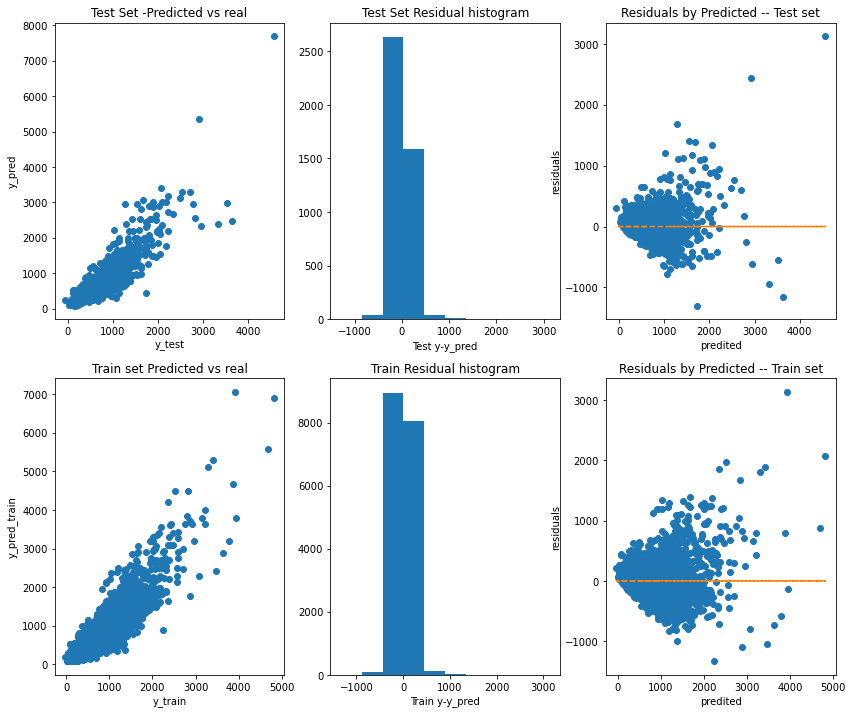

In [96]:
# Make an scatter plot y_pred vs y

fig, ax = plt.subplots(2,3,figsize=(14,12))
ax[0,0].plot(y_pred, y_test, 'o')
ax[0,0].set_xlabel("y_test")
ax[0,0].set_ylabel("y_pred")
ax[0,0].set_title("Test Set -Predicted vs real")

# Get a histogram of the residuals ie: y - y_pred
ax[0,1].hist(y_test - y_pred)
ax[0,1].set_xlabel("Test y-y_pred")
ax[0,1].set_title("Test Set Residual histogram")

ax[0,2].plot(y_pred,y_test - y_pred,"o")
ax[0,2].set_xlabel("predited")
ax[0,2].set_ylabel("residuals")
ax[0,2].set_title("Residuals by Predicted -- Test set")
ax[0,2].plot(y_pred,np.zeros(len(y_pred)),linestyle='dashed')

ax[1,0].plot(y_pred_train, y_train, 'o')
ax[1,0].set_xlabel("y_train")
ax[1,0].set_ylabel("y_pred_train")
ax[1,0].set_title("Train set Predicted vs real")

# Get a histogram of the residuals ie: y - y_pred. 
ax[1,1].hist(y_train - y_pred_train)
ax[1,1].set_xlabel("Train y-y_pred")
ax[1,1].set_title("Train Residual histogram")

ax[1,2].plot(y_pred_train,y_train - y_pred_train,"o")
ax[1,2].set_xlabel("predited")
ax[1,2].set_ylabel("residuals")
ax[1,2].set_title("Residuals by Predicted -- Train set")
ax[1,2].plot(y_pred_train,np.zeros(len(y_pred_train)),linestyle='dashed')

In [97]:
R2_train=r2_score(y_train,y_pred_train)
R2_test=r2_score(y_test,y_pred)

print (R2_train)
print(R2_test)

0.8391284735838642
0.8139345345831628


In [98]:
#MSE
train_mse=mse(y_train,y_pred_train)
test_mse=mse(y_test,y_pred)

print ('train MSE: {} -- test MSE: {}'.format(train_mse, test_mse))

train MSE: 21249.596358396062 -- test MSE: 27245.916627442075


In [99]:
#RSME
print ('train RMSE: {} -- test RMSE: {}'.format(train_mse**.5, test_mse**.5))

train RMSE: 145.77241288527833 -- test RMSE: 165.06337154996584


In [100]:
#MAE

train_mae=mae(y_train,y_pred_train)
test_mae=mae(y_test,y_pred)

print ('train MAE: {} -- test MAE: {}'.format(train_mse, test_mse))

train MAE: 21249.596358396062 -- test MAE: 27245.916627442075


In [101]:
Adj_R2_train= 1 - (1-R2_train)*(len(y_train)-1)/(len(y_train)-x_train.shape[1]-1)
Adj_R2_train

0.8362853832790136

In [102]:
Adj_R2_test= 1 - (1-R2_test)*(len(y_test)-1)/(len(y_test)-x_test.shape[1]-1)
Adj_R2_test

0.8000455971298035

In [103]:
features_importances = pd.DataFrame(data={
    'Attribute': x_train.columns,
    'Importance': abs(model.coef_)
})
features_importances = features_importances.sort_values(by='Importance', ascending=False)

In [104]:
features_importances

,Attribute,Importance
39,grade_13,1.714632e+03
254,zipcode_98039,1.232744e+03
32,waterfront_1,8.164406e+02
233,zipcode_98004,7.292867e+02
278,zipcode_98112,5.926352e+02
...,...,...
76,yr_built_1930,4.956842e-01
0,sqft_living,1.502748e-01
1,sqft_living15,3.787170e-02
171,yr_renovated_1954,4.263256e-13


In [105]:
#Lasso modelling
lasso_model = Lasso().fit(x_train,y_train)
lasso_model.intercept_

91.0060679337987

In [106]:
lasso_model.predict(x_train)

array([570.60352384, 638.15685518, 449.33569909, ..., 284.82358134,
       318.26975564, 967.56142118])

In [107]:
y_pred = lasso_model.predict(x_test)

In [108]:
mean_squared_error(y_test,y_pred)

37320.518322206895

In [109]:
r2_score(y_test, y_pred)

0.7451339330523763

In [110]:
#RandomForest Regression
RFR=RandomForestRegressor(n_estimators=100, random_state = 42)
RFR.fit(x_train,y_train)

RandomForestRegressor(random_state=42)

In [111]:
RFR_pred=RFR.predict(x_test)
#R2 score
r2_score(y_test,RFR_pred)

0.822981436778331

In [112]:
#MSE
mean_squared_error(y_test,RFR_pred)

25921.161695655206